In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.optimize import minimize
from scipy.special import erf

from numpy import sqrt
from tqdm import tqdm 
import itertools
from numpy import cos 
from numpy import tan

# Making the uncertainty sphere 

The covariance matrix is constructed using AutoNav Data

In [6]:
covariance= np.array([[2677226.887245484, 285.21446641916737, 268.99258277423775, 0.4395130785408834, 0.04869538309075001, 0.04977713754424471], 
               [285.21446641916737, 0.9848154379616082, 0.9539977104619806, 5.143220640656547e-05, 2.402194457343449e-05, 1.1448019563650868e-05], 
               [268.99258277423775, 0.9539977104619806, 0.9362931818523705, 4.7953059657441394e-05, 2.0087537013333486e-05, 1.0905119663080185e-05], 
               [0.4395130785408834, 5.143220640656547e-05, 4.7953059657441394e-05, 9.116068280599878e-08, 9.657403280723735e-09, 9.569364053017187e-09], 
               [0.04869538309075001, 2.402194457343449e-05, 2.0087537013333486e-05, 9.657403280723735e-09, 2.632076219713602e-09, 1.587031182752267e-09], 
               [0.04977713754424471, 1.1448019563650868e-05, 1.0905119663080185e-05, 9.569364053017187e-09, 1.587031182752267e-09, 1.6117378623661833e-09]])

position_covariances= covariance[:3, :3] 
# since the covariance matrix is a 6x6 matrix for each state, position_covariances extracts a 3x3 
# matrix for the covariances relating the x, y, and z positions to each other 

# the radius in the x, y, and z directions of the uncertainty sphere is calculated using the means of each row of the position_covariances 
# matrix. Because the x positions are much larger than the y and z, the x radius was scaled by 1e-4 so it would be on the same magnitude as 
# the y and z radii

x_rad = np.mean(position_covariances[0]) * 1e-4
y_rad = np.mean(position_covariances[1])
z_rad = np.mean(position_covariances[2])

print(x_rad, y_rad, z_rad)

89.25936980982259 95.71775985586366 90.29429122218403


The field of view for rectilinear equations is: 
\begin{align} \text{FOV}  & = 2 \, \times \, \text{WD} \times \tan \left( \frac{ \text{AFOV} }{2} \right) \\ \end{align}


This information was obtained from: https://www.edmundoptics.com/knowledge-center/application-notes/imaging/understanding-focal-length-and-field-of-view

This is used in the information cost equation. In order to account for the orientation of the spacecraft with respect to the uncertainty sphere, an additional $\cos(\phi)$ term is added, making the new equation: 

\begin{align} \text{FOV}  & = 2 \, \times \, \text{WD} \times \tan \left( \frac{ \text{AFOV} }{2} \right) \times \cos(\phi) \\ \end{align}

Logically, we want to obtain the largest field of view of the ISO as we can get.

Now, to find the percent of the ISO ellipsoid that is viewed by the camera, we divide this field of view by volume of the ellipsoid, which is defined as: $$V= \frac{4}{3}\pi(x_{rad}y_{rad}z_{rad})$$
This formula was obtained from https://en.wikipedia.org/wiki/Ellipsoid

This then becomes $$\text{percent viewed} = 2 \times \sqrt{\mu_{1}^2+\mu_{2}^2+\mu_{3}^2} \times \tan \left( \frac{\text{AFOV}}{2} \right) \times \frac{\cos(\phi)}{\frac{4}{3}\pi(x_{rad}y_{rad}z_{rad})}$$


Next, the cost function becomes $$\text{cost}= \sqrt{\mu_{1}^2+\mu_{2}^2+\mu_{3}^2}\times (\text{1 - percent viewed})^2$$. Ideally we would like the percent of the ISO ellipsoid to be 100%, so when percent viewed=1, the cost becomes 0. 

We can substitute the percent viewed equation into this, as well as call the distance from the ISO as $\sqrt{\mu_1^2+ \mu_2^2+\mu_3^2}$ because this is the magnitude of the distance from the ISO, (which is at the origin) and the spacecraft, which has an x, y, and z position of $\mu_1, \mu_2, \mu_3$, respectively.

This final equation is shown in the code cell below

Next, to obtain the expected values of the 6 spacecraft states, the cost function above is substituted in place of F in this equation: $$E
= \int_{-\infty}^{\infty} \cdots \int_{-\infty}^{\infty} \left( f_1(x_{f,1}) f_2(x_{f,2}) \cdots f_N(x_{f,N}) \right) F(x_{f,1}x_{f,2}\cdots x_{f, N}) \, dx_{f,1} \, dx_{f,2} \cdots \, dx_{f,N}$$

The full integrated form of E is shown below:

In [7]:
x1, x2, x3, x4, x5, x6, mu1, sigma1, mu2, sigma2, mu3, sigma3, mu4, sigma4, mu5, sigma5, mu6, sigma6 = sym.symbols('x1 x2 x3 x4 x5 x6 mu1 sigma1 mu2 sigma2 mu3 sigma3 mu4 sigma4 mu5 sigma5 mu6 sigma6')

theta, phi= sym.symbols('theta phi')
total_overlap, orth_distance= sym.symbols('total_overlap, orth_distance')

def normal_pdf(x, mu, sigma):
    return (1 / (sym.sqrt(2 * sym.pi) * sigma)) * sym.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


def info_cost(mu1, mu2, mu3, theta, phi):
    cost= total_overlap-orth_distance
    return cost

integrand = normal_pdf(x1, mu1, sigma1) * normal_pdf(x2, mu2, sigma2)*normal_pdf(x3, mu3, sigma3) * info_cost(mu1, mu2, mu3, theta, phi)

integral_expr = sym.integrate(integrand, (x1, -(mu1**2*sigma1), (mu1**2*sigma1)), (x2,  -(mu2**2*sigma2), (mu2**2*sigma2)), (x3,  -(mu3**2*sigma3), (mu3**2*sigma3)))

display(sym.simplify(integral_expr))

#the full equation for the expectation function is shown below:

(orth_distance - total_overlap)*(-erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqr

In [8]:
#these are symbols used in the portion of the cost function for the second spacecraft (ignore for now)
mu1_2, mu2_2, mu3_2, mu4_2, mu5_2, mu6_2, theta_2, phi_2= sym.symbols('mu1_2, mu2_2, mu3_2, mu4_2, mu5_2, mu6_2, theta_2, phi_2')


Because the standard deviations are constant, I substituted in 1 for them. I will later change them to the actual values obtained by AutoNav. 

In [9]:
result_expr = integral_expr.subs({
    sigma1: 1, sigma2: 1, sigma3: 1, sigma4: 1, sigma5: 1, sigma6: 1
}).simplify().simplify()

In [10]:
display(result_expr)

-(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8

In [11]:
print(result_expr)

-(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8


Here, we are obtaining a sample of POIs. This code was taken from online, but it samples 1000 points in or on the uncertainty ellipsoid

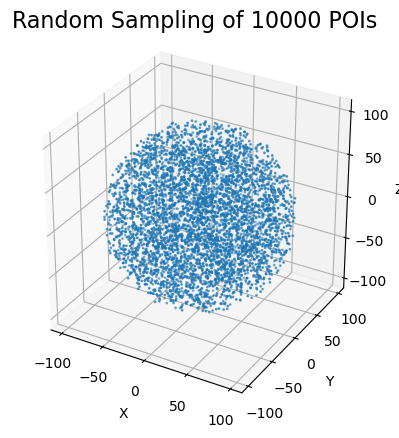

In [5]:
# Seed for reproducibility
# np.random.seed(42)

# Ellipsoid radii
x_rad, y_rad, z_rad = 100, 100, 100
a, b, c = x_rad, y_rad, z_rad

# Function to generate a random point inside a unit sphere using rejection sampling
def randompoint(ndim=3):
    while True:
        point = np.random.uniform(-1, 1, size=(ndim,))
        if np.linalg.norm(point) <= 1:
            return point

# Function to scale points from the unit sphere to the ellipsoid
f = lambda x, y, z: np.multiply(np.array([a, b, c]), np.array([x, y, z]))

# Generate points until we have, let's say, 5000 points
n = 5000
points = []
while len(points) < n:
    x, y, z = randompoint()
    scaled_point = f(x, y, z)
    points.append(scaled_point)

# Convert list to numpy array for easier handling
points = np.array(points)

# Plot the generated points
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

# Set aspect ratio for the axes
ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2])))

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Random Sampling of 10000 POIs", fontsize=16)

plt.show()


Now the function is optimized. For this optimization, I decided on 2 spacecrafts in the swarm. To make sure the optimization does not converge to the same states for both spacecrafts, I modeled both spacecrafts in the same objective function by adding them together. Essentially the objective function (the function I'm trying to minimize) became $$\text{objective} = \text{cost}_{spacecraft 1} + \text{cost}_{spacecraft 2}$$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.optimize import minimize
from scipy.special import erf
from numpy import sqrt
from tqdm import tqdm 
import itertools
from numpy import cos 
from numpy import tan
import random

In [14]:
# def point_in_FOV(fov, sc, point):
#     # normalized direction vector
#     sc_dir = sc / np.linalg.norm(sc)
#     cone_dist = np.dot(sc - point, sc_dir)
#     # calculate the orth distance
#     orth_dist = np.linalg.norm((sc - point) - cone_dist * sc_dir)
#     # radius of the cone 
#     H = np.linalg.norm(sc) # technically is the height of the cone
#     R = H * np.tan(fov)
#     cone_dist = np.dot(sc - point, sc_dir)
#     r_at_p = (cone_dist / H) * R
#     if (r_at_p >= orth_dist):
#         return True
#     else:
#         return False

# # x is the initial positions of each of the spacecraft
# def info_cost(x):
#     if len(x) % 3 != 0:
#         raise TypeError
#     # the FOV value is the same for every s/c
#     cost = 0
#     all_pois = {}
#     fov = np.pi / 4
#     for i in range(3, len(x), 3):
#         # the position of the current s/c
#         sc = np.array([x[i - 2], x[i - 1], x[i]])
#         pois = []
#         for point in points:
#             if point_in_FOV(fov, sc, point):
#                 # this adds the POI to the array of observed points
#                 pois.append(point)
#         # iterating through the other spacecraft
#         pois = np.array(pois)
#         total_overlap = 0
#         for j in range(i + 3, len(x), 3):
#             for sc2 in all_pois:
#                 overlap = np.intersect1d(sc2, pois)
#                 total_overlap += overlap
#         all_pois[i / 3] = pois 
#         mu1, mu2, mu3 = sc[0], sc[1], sc[2]
#         # total number of POIs - observed POIs
#         cost += (10000 - len(pois) + 1) * (np.linalg.norm(sc)) * (erf(sqrt(2) * mu1 * (mu1 - 1) / 2) * erf(sqrt(2) * mu2 * (mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8
#     if total_overlap > 0:
#         cost *= total_overlap
#     print(cost)
#     return cost



In [15]:

x = np.array([100, 200, 300, 100, 200, 300, 100, 200, 300])

#all of the variables are unbounded except for the angles. In the FOV equation, we see that AFOV is bounded by arctan, which has 
#bounds of -90 to 90 degrees. Phi was left as bounded by the standard angle range, 0-360 degrees.
# bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf)] * 3

# result = minimize(info_cost, x, method = "Nelder-Mead")


In [16]:
# pos_1 = result.x[:3]
# pos_2 = result.x[3:6]
# pos_3 = result.x[6:]
# pos_1, pos_2, pos_3


In [7]:
# Define the objective function to minimize
def objective_function(x):
    fov = np.pi/4
    init_vals=x
    apex=np.array([0, 0, 0])
    pos = 0
    norm_pos = 0
    total_overlap = 0.0
    tot_vol=0 
    orth_dist=0


    for i in range(3, len(init_vals), 4):
        fov_range = [np.degrees(fov) -  init_vals[i]/ 2, np.degrees(fov) + init_vals[i] / 2]
        pos = np.array([init_vals[i-3], init_vals[i-2], init_vals[i-1]]) *1e2
        mu1=pos[0]
        mu2=pos[1]
        mu3=pos[2]
        origin=pos
        norm_pos = (pos[0]**2+pos[1]**2+pos[2]**2)**0.5
        distance= ((origin - apex)[0]**2+(origin - apex)[1]**2+(origin - apex)[2]**2)**0.5
        
        #arr=[]
        direction_vector = origin - apex
        vec = origin - apex
        direction_vector = direction_vector / np.linalg.norm(direction_vector)

        xx, yy = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))

        d = np.dot(direction_vector, apex)
        zz = (d - direction_vector[0] * xx - direction_vector[1] * yy) / direction_vector[2]
        
        for point in points: 
            if np.dot(point, origin)>0:
                vec = origin - apex
                vec_norm = vec/((vec[0]**2+vec[1]**2+vec[2]**2)**0.5)
                cone_dist = np.dot(origin-point, vec_norm)
                cone_radius = (cone_dist / distance) * 50
                orth_distance = (((origin-point)-cone_dist*vec_norm)[0]**2+((origin-point)-cone_dist*vec_norm)[1]**2+((origin-point)-cone_dist*vec_norm)[2]**2)**0.5
                orth_dist = orth_dist+orth_distance
        

        for j in range(i + 4, len(init_vals), 4):
            start1, end1 = init_vals[i] - fov / 2, init_vals[i] + fov / 2
            start2, end2 = init_vals[j] - fov / 2, init_vals[j] + fov / 2
            overlap_start = max(start1, start2)
            overlap_end = min(end1, end2)
    
            overlap= max(0, overlap_end-overlap_start)
                
            total_overlap= total_overlap+overlap
                
            if np.abs(init_vals[i] - init_vals[j]) < 0.01:
                if init_vals[j]==0:
                    init_vals[j]= init_vals[j]+0.01
                #total_overlap= total_overlap+np.cos(init_vals[i] / init_vals[j])
    

    cost= -(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8
    return cost

In [11]:

res3 = []
pos_hist3 = []
res_cost3 = []
for j in range(0, 2):
    for i in tqdm (range (1, 8)):
        x = []
        for k in range(i):
            x.append([(np.random.randint(100, 250) * random.choice([-1, 1])), (np.random.randint(100, 250) * random.choice([-1, 1])), (np.random.randint(100, 250) * random.choice([-1, 1])), (np.random.uniform(0, 2*np.pi))])
        pos_hist3.append(x)
        x = np.array(x).flatten()
        bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0, 2 * np.pi)] * i
        result = minimize(objective_function, x, method = "Nelder-Mead", bounds = bounds)
        res3.append(result.x)
        res_cost3.append(result.fun)

# x = np.array([100, 200, 300, (np.random.uniform(0, 2*np.pi))]) # 1 spacecraft
# x = np.array([100, 200, 300, (np.random.uniform(0, 2*np.pi))], [100, 200, 300, (np.random.uniform(0, 2*np.pi))])

# bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0, 2 * np.pi)] * 8

# result= minimize(objective_function, x, method= "Nelder-Mead", bounds = bounds) # I chose to use the Nelder-Mead method of 

100%|██████████| 7/7 [27:17<00:00, 233.86s/it]


In [20]:
len(res3)
len(res3[7:])

7

In [33]:
# split the results into 2
t1 = res3[:7]
t2 = res3[7:]

t1_cost = res_cost3[:7]
t2_cost = res_cost3[7:]
# t3_cost = res_cost3[18:27]

t1_pos = pos_hist3[:7]
t2_pos = pos_hist3[7:]
# t3_pos = pos_hist3[18:27]

min_cost1 = min(t1_cost)
min_cost2 = min(t2_cost)
# min_cost3 = min(t3_cost)

# find the index of the minimum cost
min_cost1_index = t1_cost.index(min_cost1)
min_cost2_index = t2_cost.index(min_cost2)
# min_cost3_index = t3_cost.index(min_cost3)

# find the position of the minimum cost
min_cost1_pos = t1_pos[min_cost1_index]
min_cost2_pos = t2_pos[min_cost2_index]
# min_cost3_pos = t3_pos[min_cost3_index]

print(min_cost1, min_cost2)
print(min_cost2_pos)
print(t1_cost, t2_cost)


-99.30590263802729 -95.71329145096031
[[150, -159, -229, 3.787474203817259], [-201, -133, -104, 2.5066013187740017], [-241, -126, -108, 2.2087588299983687], [-228, -118, 201, 4.7301363644581285], [-232, -233, 115, 0.02853075839836516], [-103, 226, 230, 3.326982119254341], [180, -206, -223, 5.825672483668356]]
[-95.71329145094775, -99.3059026380254, -99.30590263802729, -95.71329145095206, -95.71329145094853, -95.71329145096269, -99.30590263802372] [-95.7132914509485, -95.71329145094866, -95.71329145094836, -95.71329145094904, -95.7132914509494, -95.7132914509495, -95.71329145096031]


In [27]:
print(t2)

[array([  70.50875822, -132.08989547,  269.95139452,    5.43412295]), array([-115.24905595, -239.02576527,  -66.10035096,    5.09760526,
        110.94567324, -104.54621026,  301.63374845,    6.08535573]), array([ 148.82487155, -187.16809268, -240.82046692,    4.39267817,
       -131.48109735,  220.89821162,  214.74728047,    5.25110476,
         19.17254882,  163.60314778, -164.43332697,    2.89105617]), array([ 114.97512816,  105.47709925, -224.36718072,    2.29248519,
       -194.82556753,  167.59180141,  260.19372849,    4.82451689,
        147.49213022, -159.64061774, -146.60874557,    5.89357075,
       -165.42286287, -116.15738244, -125.46152999,    3.37953549]), array([-122.17907611,  178.01692639,  131.16419602,    1.12739908,
        164.9319732 , -184.24679274,  225.39248177,    4.33202518,
       -244.75377095,  200.32071127, -171.72728396,    6.16341498,
        140.24372606,  203.70222728,  159.03098277,    5.2432854 ,
        194.52052486,  155.5413729 ,  124.938265  ,  

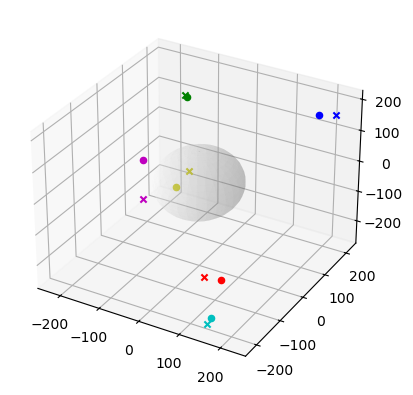

In [52]:
# plot the positions of the spacecrafts that gave the min cost
ax = plt.axes(projection='3d')
min_trial_t_pos = np.array(t1[min_cost1_index])
ax.scatter(min_trial_t_pos[0], min_trial_t_pos[1], min_trial_t_pos[2], color = 'r')
ax.scatter(t1_pos[min_cost1_index][0][0], t1_pos[min_cost1_index][0][1], t1_pos[min_cost1_index][0][2], marker = 'x', color = 'r')
ax.scatter(min_trial_t_pos[4], min_trial_t_pos[5], min_trial_t_pos[6], color = 'b')
ax.scatter(t1_pos[min_cost1_index][1][0], t1_pos[min_cost1_index][1][1], t1_pos[min_cost1_index][1][2], marker = 'x', color = 'b')
ax.scatter(min_trial_t_pos[8], min_trial_t_pos[9], min_trial_t_pos[10], color = 'g')
ax.scatter(t1_pos[min_cost1_index][2][0], t1_pos[min_cost1_index][2][1], t1_pos[min_cost1_index][2][2], marker = 'x', color = 'g')
ax.scatter(min_trial_t_pos[12], min_trial_t_pos[13], min_trial_t_pos[14], color = 'y')
ax.scatter(t1_pos[min_cost1_index][3][0], t1_pos[min_cost1_index][3][1], t1_pos[min_cost1_index][3][2], marker = 'x', color = 'y')
ax.scatter(min_trial_t_pos[16], min_trial_t_pos[17], min_trial_t_pos[18], color = 'c')
ax.scatter(t1_pos[min_cost1_index][4][0], t1_pos[min_cost1_index][4][1], t1_pos[min_cost1_index][4][2], marker = 'x', color = 'c')
ax.scatter(min_trial_t_pos[20], min_trial_t_pos[21], min_trial_t_pos[22], color = 'm')
ax.scatter(t1_pos[min_cost1_index][5][0], t1_pos[min_cost1_index][5][1], t1_pos[min_cost1_index][5][2], marker = 'x', color = 'm')

r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x_rad, y_rad, z_rad = 100, 100, 100
x_sphere = x_rad * np.cos(u) * np.sin(v)
y_sphere = y_rad * np.sin(u) * np.sin(v)
z_sphere = z_rad * np.cos(v)
ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.2, color='white', label = "Uncertainty Ellipsoid")

plt.show()


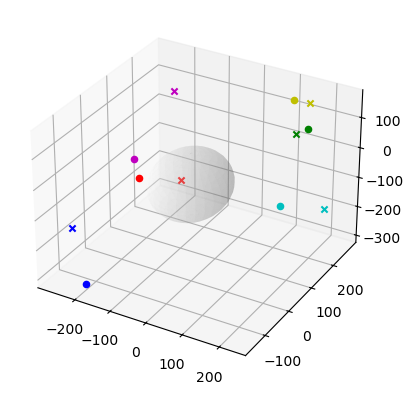

In [53]:
ax = plt.axes(projection='3d')
min_trial_t_pos = np.array(t2[min_cost2_index])
ax.scatter(min_trial_t_pos[0], min_trial_t_pos[1], min_trial_t_pos[2], color = 'r')
ax.scatter(t2_pos[min_cost2_index][0][0], t2_pos[min_cost2_index][0][1], t2_pos[min_cost2_index][0][2], marker = 'x', color = 'r')
ax.scatter(min_trial_t_pos[4], min_trial_t_pos[5], min_trial_t_pos[6], color = 'b')
ax.scatter(t2_pos[min_cost2_index][1][0], t2_pos[min_cost2_index][1][1], t2_pos[min_cost2_index][1][2], marker = 'x', color = 'b')
ax.scatter(min_trial_t_pos[8], min_trial_t_pos[9], min_trial_t_pos[10], color = 'g')
ax.scatter(t2_pos[min_cost2_index][2][0], t2_pos[min_cost2_index][2][1], t2_pos[min_cost2_index][2][2], marker = 'x', color = 'g')
ax.scatter(min_trial_t_pos[12], min_trial_t_pos[13], min_trial_t_pos[14], color = 'y')
ax.scatter(t2_pos[min_cost2_index][3][0], t2_pos[min_cost2_index][3][1], t2_pos[min_cost2_index][3][2], marker = 'x', color = 'y')
ax.scatter(min_trial_t_pos[16], min_trial_t_pos[17], min_trial_t_pos[18], color = 'c')
ax.scatter(t2_pos[min_cost2_index][4][0], t2_pos[min_cost2_index][4][1], t2_pos[min_cost2_index][4][2], marker = 'x', color = 'c')
ax.scatter(min_trial_t_pos[20], min_trial_t_pos[21], min_trial_t_pos[22], color = 'm')
ax.scatter(t2_pos[min_cost2_index][5][0], t2_pos[min_cost2_index][5][1], t2_pos[min_cost2_index][5][2], marker = 'x', color = 'm')

r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x_rad, y_rad, z_rad = 100, 100, 100
x_sphere = x_rad * np.cos(u) * np.sin(v)
y_sphere = y_rad * np.sin(u) * np.sin(v)
z_sphere = z_rad * np.cos(v)
ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.2, color='white', label = "Uncertainty Ellipsoid")

plt.show()

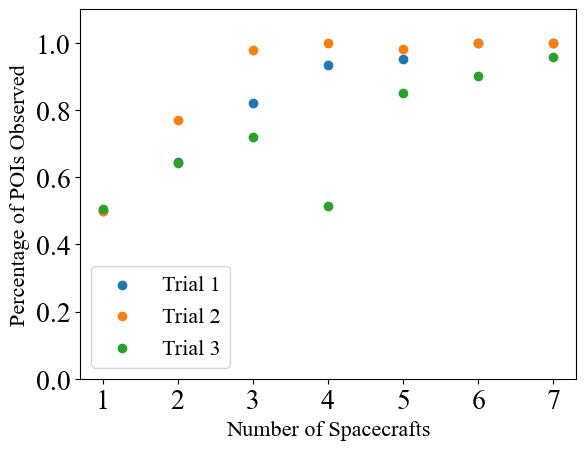

[0.5015333333333333,
 0.6861333333333333,
 0.8392000000000001,
 0.8160666666666666,
 0.9274,
 0.967,
 0.9859333333333332]

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

data1 = [[1, 0.4996], [2, 0.6458], [3, 0.8194], [4, 0.9342], [5, 0.9522], [6, 1.0], [7, 1.0]]
data2 = [[1, 0.5006], [2, 0.7704], [3, 0.9776], [4, 1.0], [5, 0.981], [6, 0.9994], [7, 1.0]]
data3 = [[1, 0.5044], [2, 0.6422], [3, 0.7206], [4, 0.514], [5, 0.849], [6, 0.9016], [7, 0.9578]]

plt.scatter(*zip(*data1), label="Trial 1")
plt.scatter(*zip(*data2), label="Trial 2")
plt.scatter(*zip(*data3), label="Trial 3")

plt.legend()
plt.xlabel("Number of Spacecrafts")
plt.ylabel("Percentage of POIs Observed")

plt.ylim(0, 1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# find the avergae of percentage of POIs observed for each number of spacecrafts
data = [data1, data2, data3]
average = []
for i in range(7):
    total = 0
    for j in range(3):
        total += data[j][i][1]
    average.append(total / 3)
average


[-95.1393120992824, -95.25108395202534, -96.56903382700587, -95.55883943616347, -96.1430138892951, -82.90781926139711, -69.03634888182783]


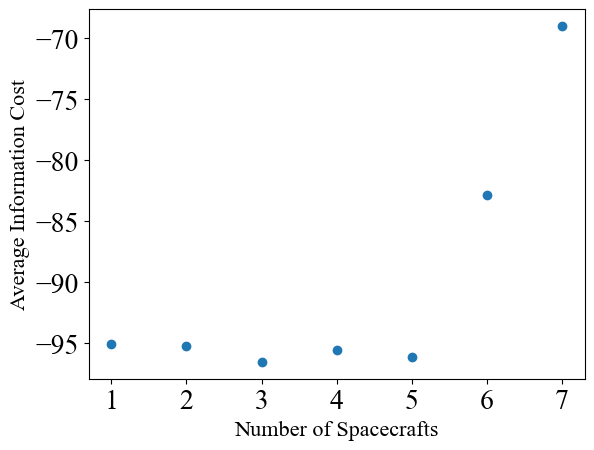

In [55]:
cost = [[-95.71329145094775, -99.3059026380254, -99.30590263802729, -95.71329145095206, -95.71329145094853, -95.71329145096269, -99.30590263802372], [-95.7132914509485, -95.71329145094866, -95.71329145094836, -95.71329145094904, -95.7132914509494, -95.7132914509495, -95.71329145096031], [-93.99135339595097,-90.73405776710196,-94.68790739204194,-95.2499354065893,-97.0024587659874,-57.29687488227913,-12.089852556499473]]

#find the average cost 
average_cost = []
for i in range(7):
    total = 0
    for j in range(3):
        total += cost[j][i]
    average_cost.append(total / 3)

print(average_cost)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

#plot the average cost of the trials
plt.scatter([1, 2, 3, 4, 5, 6, 7], average_cost)

plt.xlabel("Number of Spacecrafts")
plt.ylabel("Average Information Cost")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [34]:
l = [([[-311.18484314, -239.98553706, -467.37949359,    1.95984805]]),
 ([[ 4.67005901e+02, -2.86026790e+02,  7.75562604e+01,  5.79679798e-03],
         [3.34430603e+01, -2.84090173e+02,  1.59615802e+02,  9.17495594e-01]]),
 ([ [512.14077576, -283.25901924, -483.90205944,    5.44196187],
         [349.69908217, -171.43083135, -548.52790012,    2.17366156],
        [-494.35041249, -268.32419312, -782.34210202,    6.27941442]]),
 ([ [219.27577115, -159.79733232,  469.70876978,    4.82443617],
         [253.65942005, -142.57460908,  499.68966252,    4.0390375],
         [236.95692324, -158.172057  ,  528.25236132,    6.28318491],
         [247.3350109 , -162.06572995,  480.22018376,    5.60983367]]),
 ([[-5.59188661e+02,  3.20864486e+02,  6.97547285e+02,  1.78355269e+00],
        [-9.66252370e+01,  3.50190863e+02,  7.26028633e+02,  4.34725838e+00],
        [-1.40488250e+02,  2.98905884e+02, -1.09523832e+02,  9.25357637e-01],
        [-1.34195248e+03,  8.64266810e+01, -5.17452015e+02,  3.23349806e+00],
        [-1.08924417e+03, -3.38737956e+02,  5.60796149e+02,  9.32713955e-02]]),
 ([ [339.        , -405.        ,  156.        ,    5.53561156],
         [339.        , -405.        ,  156.        ,    5.53561156],
         [339.        , -405.        ,  156.        ,    5.81239213],
         [339.        , -405.        ,  156.        ,    5.53561156],
         [339.        , -405.        ,  156.        ,    5.53561156],
         [339.        , -405.        ,  156.        ,    5.53561156]]),
 ([ [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [470.50714286, -391.08392857, -541.8875    ,    3.81284231],
         [421.2       , -391.08392857, -541.8875    ,    3.81284231]]),
]

# run each positions and put it thru the objective function
cost = []
for trial in l:
    cost.append(objective_function(np.array(trial).flatten()))

cost

[-93.99135339595097,
 -90.73405776710196,
 -94.68790739204194,
 -95.2499354065893,
 -97.0024587659874,
 -57.29687488227913,
 -12.089852556499473]